In [1]:
import sys
import pandas as pd
import allel

In [2]:
sys.path.insert(0, '../../agam-report-base/src/python')
from ag1k import phase2_ar1
from util import fig_linear_genome

In [3]:
release_dir = '/kwiat/vector/ag1000g/release/phase2.AR1/'

In [4]:
phase2_ar1.init(release_dir)

In [5]:
# USE THE FULL CALLSET_PASS IE NOT PHASED (BIALLELIC ONLY). I JUST DON'T HAVE THE FULL CALLSET ON THIS LAPTOP
# THIS WILL RESULT IN AN UNDERESTIMATE OF DIVERSITY
phase2_ar1.callset_phased.keys()

dict_keys(['3R'])

In [6]:
gt = allel.GenotypeDaskArray(phase2_ar1.callset_phased["3R"]['calldata/genotype'])
gt.shape

(10752701, 1164, 2)

In [7]:
subpops = phase2_ar1.df_samples.groupby("population").indices

In [8]:
subpops_ix = {k: list(v) for k, v in subpops.items()}

In [9]:
ac = gt.count_alleles_subpops(subpops_ix)

In [10]:
pos = allel.SortedIndex(phase2_ar1.callset_phased["3R"]["variants/POS"])

In [11]:
ac['KE']

<AlleleCountsDaskArray shape=(10752701, 2) dtype=int64>

In [12]:
window_size = 50000
eqa = allel.equally_accessible_windows(phase2_ar1.accessibility['3R']['is_accessible'], window_size)

In [13]:
# takes some allele frequencies, sums the alt frequencies. This gives us the mean number of alleles differnt from the 
# refernce genome. Divide by 2 because diploid.
def compute_divergence(allele_freqs):
    sum_alt = allele_freqs.sum(axis=0)
    return (sum_alt[1:].sum() / 2)
    

In [14]:
# use the start of the window as the index
rdf = pd.DataFrame(index=eqa[:, 0], columns=subpops.keys())

In [15]:
rdf.head()

,AOcol,BFcol,BFgam,CIcol,CMgam,FRgam,GAgam,GHcol,GHgam,GM,GNcol,GNgam,GQgam,GW,KE,UGgam
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
import numpy as np

In [17]:
for pop in subpops.keys():
    print("processing", pop)
    
    # Faster if we drop non variant loci first, and load into mem
    loc = ac[pop].is_variant().compute()
    pop_ac = ac[pop].compress(loc, axis=0).compute()
    pop_pos = pos.compress(loc, axis=0)
    print("computing divergence...", loc.sum())
    
    vals, windows, counts = allel.windowed_statistic(
        pop_pos, pop_ac.to_frequencies(), compute_divergence, windows=eqa)
    rdf[pop] = vals / window_size

processing AOcol
computing divergence... 1250955
processing BFcol
computing divergence... 3213429
processing BFgam
computing divergence... 3772111
processing CIcol
computing divergence... 2477184
processing CMgam
computing divergence... 6064180
processing FRgam
computing divergence... 700644
processing GAgam
computing divergence... 1665455
processing GHcol
computing divergence... 2277664
processing GHgam
computing divergence... 1374370
processing GM
computing divergence... 2348274
processing GNcol
computing divergence... 679642
processing GNgam
computing divergence... 2602909
processing GQgam
computing divergence... 1059905
processing GW
computing divergence... 3397939
processing KE
computing divergence... 575026
processing UGgam
computing divergence... 3666528


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

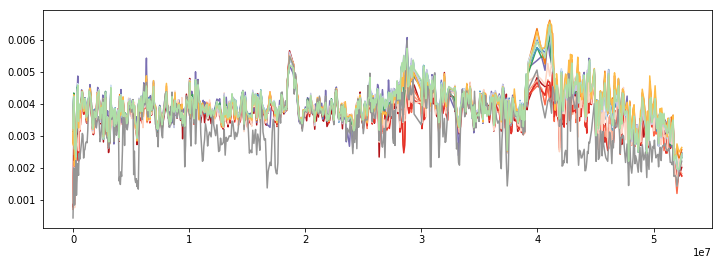

In [19]:
f, ax = plt.subplots(figsize=(12, 4))
for pop in subpops.keys():
    ax.plot(rdf.index, rdf[pop], c=phase2_ar1.pop_colors[pop])